##Emotional loyalty model demo

This notebook will walk you through a demo model implementing emotional loyalty scoring. The goal of this loyalty model is to account for the "emotional" engagement of the consumer with the service/product alongside with the transactional parameters like the frequency of purchases and purchase amount. 


Let's start by importing the libraries, loading the dataset and adding a random seed for reproducibility of the model.

In [178]:
!pip install -q opendatasets

In [216]:
# Import the necessary libraries
import os
import numpy as np
import pandas as pd
import opendatasets as od
import random
import re
import matplotlib.pyplot as plt

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Random seed for reproducibility
random.seed(42)
np.random.seed(42)

In [217]:
# Import the dataset
od.download("https://www.kaggle.com/datasets/bhadramohit/customer-shopping-latest-trends-dataset")

Skipping, found downloaded files in ".\customer-shopping-latest-trends-dataset" (use force=True to force download)


In [218]:
data_dir = "customer-shopping-latest-trends-dataset"
print(os.listdir(data_dir))

csv_path = os.path.join(data_dir, "shopping_trends.csv")
df = pd.read_csv(csv_path)

print(f"Loaded {len(df):,} rows and {df.shape[1]} columns.")
df.head()

['shopping_trends.csv']
Loaded 3,900 rows and 19 columns.


,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Payment Method,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Preferred Payment Method,Frequency of Purchases
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Credit Card,Express,Yes,Yes,14,Venmo,Fortnightly
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Bank Transfer,Express,Yes,Yes,2,Cash,Fortnightly
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Cash,Free Shipping,Yes,Yes,23,Credit Card,Weekly
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,PayPal,Next Day Air,Yes,Yes,49,PayPal,Weekly
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Cash,Free Shipping,Yes,Yes,31,PayPal,Annually


Now we want to get rid of the columns that do not give us any useful information (in real/larger datasets we would drop different columns, but for this demo we make the following choices).

In [219]:
# Check what columns we currently have
print(df.columns.tolist())

['Customer ID', 'Age', 'Gender', 'Item Purchased', 'Category', 'Purchase Amount (USD)', 'Location', 'Size', 'Color', 'Season', 'Review Rating', 'Subscription Status', 'Payment Method', 'Shipping Type', 'Discount Applied', 'Promo Code Used', 'Previous Purchases', 'Preferred Payment Method', 'Frequency of Purchases']


In [220]:
# Drop the columns that we will not use for the model
df = df.drop(columns= ['Item Purchased', 'Location', 'Size', 'Color', 'Shipping Type', 'Payment Method', 'Preferred Payment Method', 'Age', 'Gender', 'Category', 'Season'])

print(df.columns.tolist())

['Customer ID', 'Purchase Amount (USD)', 'Review Rating', 'Subscription Status', 'Discount Applied', 'Promo Code Used', 'Previous Purchases', 'Frequency of Purchases']


In [221]:
# Check how the dataset looks now
df.head()

,Customer ID,Purchase Amount (USD),Review Rating,Subscription Status,Discount Applied,Promo Code Used,Previous Purchases,Frequency of Purchases
0,1,53,3.1,Yes,Yes,Yes,14,Fortnightly
1,2,64,3.1,Yes,Yes,Yes,2,Fortnightly
2,3,73,3.1,Yes,Yes,Yes,23,Weekly
3,4,90,3.5,Yes,Yes,Yes,49,Weekly
4,5,49,2.7,Yes,Yes,Yes,31,Annually


Now we need to do more preprocessing by changing yes/no to 1/0; translating frequencies into floats; making sure the categorical values and the names of columns are consistent. 

In [222]:
# Write the columns with numerical and categorical entries out
Categorical = ['Subscription Status', 'Discount Applied', 'Promo Code Used', 'Frequency of Purchases']
Numerical = ['Customer ID','Purchase Amount (USD)', 'Review Rating', 'Previous Purchases']

for cat in Categorical:
    vals = (df[cat]
          .astype(str)
          .str.strip()
          .str.replace(r'\s+', ' ', regex=True)
          .str.lower()
          .unique())
    sorted(vals)
    print(vals)


['yes' 'no']
['yes' 'no']
['yes' 'no']
['fortnightly' 'weekly' 'annually' 'quarterly' 'bi-weekly' 'monthly'
 'every 3 months']


In [223]:
# Map yes/no to 0/1
def yn_to01(s):
    m = s.astype(str).str.strip().str.lower()
    return m.map({"yes":1,"no":0}).astype(float)

# Apply to the dataset
df['Subscription Status'] = yn_to01(df['Subscription Status'])
df['Discount Applied']    = yn_to01(df['Discount Applied'])
df['Promo Code Used']     = yn_to01(df['Promo Code Used'])

# Turn strings like 'Monthly' into events per year
freq_map = {
    "daily":365, "weekly":52, "fortnightly":26, "bi-weekly":26,
    "monthly":12, "every 3 months":4, "quarterly":4, "annually":1,
}
df["Frequency of Purchases"] = df["Frequency of Purchases"].astype(str).str.lower().map(freq_map).fillna(1.0)


In [224]:
# Check what we got
df.head()

,Customer ID,Purchase Amount (USD),Review Rating,Subscription Status,Discount Applied,Promo Code Used,Previous Purchases,Frequency of Purchases
0,1,53,3.1,1.0,1.0,1.0,14,26
1,2,64,3.1,1.0,1.0,1.0,2,26
2,3,73,3.1,1.0,1.0,1.0,23,52
3,4,90,3.5,1.0,1.0,1.0,49,52
4,5,49,2.7,1.0,1.0,1.0,31,1


In [225]:
# Make the column names consistent
def to_snake(name):
    name = re.sub(r"[^\w]+", "_", str(name).strip())
    name = re.sub(r"__+", "_", name)
    return name.strip("_").lower()

df.columns = [to_snake(c) for c in df.columns]
df.head()


,customer_id,purchase_amount_usd,review_rating,subscription_status,discount_applied,promo_code_used,previous_purchases,frequency_of_purchases
0,1,53,3.1,1.0,1.0,1.0,14,26
1,2,64,3.1,1.0,1.0,1.0,2,26
2,3,73,3.1,1.0,1.0,1.0,23,52
3,4,90,3.5,1.0,1.0,1.0,49,52
4,5,49,2.7,1.0,1.0,1.0,31,1


Now we create blocks that represent emotional engagement, amount of money spent and the frequency of purchases. Those block will give each consumer a score based on their "performance" in each area. 

For this we need to create a normalisation function that will help us assign scores from 0 to 100 for each block for each consumer.


In [226]:
def norm_quantile_0_100(s, invert=False):
    x = pd.to_numeric(s, errors="coerce").to_numpy().reshape(-1,1)
    qt = QuantileTransformer(
        n_quantiles=min(1000, len(s)),
        output_distribution='uniform',
        random_state=42
    )
    y = (qt.fit_transform(x).ravel() * 100)
    return (100 - y) if invert else y


In [227]:
# Create a function that fills in missing values
def nz(s):
    return pd.to_numeric(s, errors="coerce").fillna(s.median())

# Create a copy of the dataset to not alter the original one
cust = df.copy()

# Make sure the numeric values are indeed numeric
for c in ["purchase_amount_usd","previous_purchases","frequency_of_purchases",
          "subscription_status","discount_applied","promo_code_used",
          "review_rating","age"]:
    if c in cust.columns:
        cust[c] = pd.to_numeric(cust[c], errors="coerce")

# Since the data is synthetic, we only have one row per consumer, so we assume the last purchase is the average amount that they usually spend 
cust["freq_per_year"]   = cust["frequency_of_purchases"].fillna(1.0)
cust["total_spend_est"] = (cust["purchase_amount_usd"].fillna(0) * cust["freq_per_year"])
cust["avg_purchase"]    = cust["purchase_amount_usd"].fillna(0)

# Fill in the missing values for the engagement block 
cust["sub_rate"]     = cust["subscription_status"].fillna(0)
cust["discount_rate"] = cust["discount_applied"].fillna(0)   
cust["promo_rate"]    = cust["promo_code_used"].fillna(0)    
cust["avg_rating"]    = cust["review_rating"].fillna(0)

# Now we bild the blocks with scores

# Spend/Value block is estimated by annual spend and average purchase
s_spend = np.nanmean(np.vstack([
    norm_quantile_0_100(nz(cust["total_spend_est"])),
    norm_quantile_0_100(nz(cust["avg_purchase"])),
]), axis=0)

# Frequency block
s_freq = np.nanmean(np.vstack([norm_quantile_0_100(nz(cust["freq_per_year"]))]), axis=0)

# For engagement, we include sub + discounts + promos + rating (also add a cap so promo-chasers do not dominate)
s_engage = np.nanmean(np.vstack([
    norm_quantile_0_100(nz(cust["sub_rate"])),
    norm_quantile_0_100(nz(cust["discount_rate"])),
    norm_quantile_0_100(nz(cust["promo_rate"])),
    norm_quantile_0_100(nz(cust["avg_rating"])),
]), axis=0)
s_engage = np.minimum(s_engage, 90.0)

# Assemble block scores
block_scores = pd.DataFrame({
    "customer_id": cust["customer_id"],
    "s_spend": s_spend,
    "s_freq": s_freq,
    "s_engage": s_engage,
})

block_scores.head()

,customer_id,s_spend,s_freq,s_engage
0,1,56.531532,72.222222,80.930931
1,2,65.240240,72.222222,80.930931
2,3,80.755756,100.000000,80.930931
3,4,92.417417,100.000000,85.047548
4,5,21.321321,0.000000,76.926927


After the blocks that represent the parameters of interest in our model are made, we use them in unsupervised learning to find clusters of consumers that share similar behaviour with respect to those metrics.

Clustering on columns: ['s_engage', 's_freq', 's_spend']
K=4, silhouette(3D)=0.365


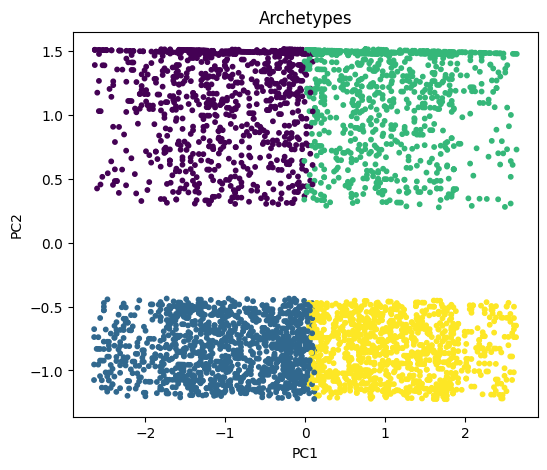

In [228]:
block_cols = sorted([c for c in block_scores.columns if c.startswith("s_")])
dims = len(block_cols)
print("Clustering on columns:", block_cols)

X  = block_scores[block_cols].values
Xs = StandardScaler().fit_transform(X)

# Perform the K-means clustering
best_k, best_sil, best_labels = None, -1, None
for k in range(3, 8):
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(Xs)
    sil = silhouette_score(Xs, labels)
    if sil > best_sil:
        best_k, best_sil, best_labels = k, sil, labels

print(f"K={best_k}, silhouette({dims}D)={best_sil:.3f}")
block_scores["cluster"] = best_labels


# Add PCA to be able to graph the clusters in 2d
X2 = PCA(n_components=2, random_state=42).fit_transform(Xs)
plt.figure(figsize=(6,5))
plt.scatter(X2[:,0], X2[:,1], s=10, c=best_labels)
plt.title("Archetypes")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.show()

# Compute the unsupervised contribution, scale it and assigns a score based on the cluster to each consumer
row_eq = block_scores[block_cols].mean(axis=1)
cluster_base = row_eq.groupby(block_scores["cluster"]).mean()
unsup = block_scores["cluster"].map(cluster_base).astype(float)
unsup = (unsup - unsup.min()) / (unsup.max() - unsup.min() + 1e-9) * 100
block_scores["unsup_signal"] = unsup


We get 4 clusters that in the real data setting would likely give us insight into the "archetypes" of consumers. This however, is a synthetic dataset, so there is unlikely to be much insight into that aspect of consumers. Although, we still have a meaningful silhouette of 0.365 even in the synthetic setting.

Next we move on to creating a function $U(x)$ that will be used in assigning the loyalty tiers. $U(x)$ is just a linear combination of contributions from each block scaled by the weights. We will be able to alter the contribution (weights) from each block (e.g. some companies care much a lot about how engaged consumers are, others not as much. Same with the frequency contribution).

In [229]:
# Choose weights (they need to sum to 1)
knobs = {
    "spend":  0.40,
    "freq":   0.30,
    "engage": 0.30,
}

# Keep only blocks that exist, then renormalise
available = [c.replace("s_","") for c in block_scores.columns if c.startswith("s_")]
knobs = {k:v for k,v in knobs.items() if f"s_{k}" in block_scores.columns}
tot = sum(knobs.values()) or 1.0
knobs = {k: v/tot for k,v in knobs.items()}
print("Using knobs:", knobs)

# Define the function U(x)
def U_from_knobs(df, weights):
    u = np.zeros(len(df))
    for k,w in weights.items():
        u += w * df[f"s_{k}"].values
    return u

block_scores["U_seed"] = U_from_knobs(block_scores, knobs)


Using knobs: {'spend': 0.4, 'freq': 0.3, 'engage': 0.3}


Now we define the function $\text{tierer}(x) = \lambda U(x) + (1-\lambda) \text{unsup_contribution}$. This function will be assigning tiers to the consumer. It will account for both the contribution due to $U(x)$ that we tune using weights, and it will account for the contribution from the unsupervised learning (cluster contribution that does not depend on the weights). Parameter $\lambda$ will be our confidence in the model based on the weight that the business chose (we are talking about $U(x)$). 

In a non-demo setting we can add a regressor to make the score distribution smoother.

In [237]:
# Set our confidence parameter and create the tierer
LAMBDA = 0.7
score = LAMBDA*block_scores["U_seed"].values + (1-LAMBDA)*block_scores["unsup_signal"].values
block_scores["score"] = np.clip(score, 0, 100)

# Add the tier distribution (has to add to 1)
TARGET_MIX = {"Platinum":0.05, "Gold":0.15, "Silver":0.30, "Regular":0.50}

# Define the function that gives us tier cutoffs
def thresholds_from_mix(scores, mix):
    cum=0; thr={}; order=["Platinum","Gold","Silver","Regular"]
    for lvl in order[:-1]:
        thr[lvl] = np.quantile(scores, 1 - (cum + mix[lvl]))
        cum += mix[lvl]
    thr["Regular"] = -np.inf
    return thr

thr = thresholds_from_mix(block_scores["score"].values, TARGET_MIX)

# Function that assigns the tiers
def to_tier(s):
    if s >= thr["Platinum"]: return "Platinum"
    if s >= thr["Gold"]:     return "Gold"
    if s >= thr["Silver"]:   return "Silver"
    return "Regular"

block_scores["tier"] = [to_tier(s) for s in block_scores["score"].values]
print((block_scores["tier"].value_counts(normalize=True)*100).round(1))


tier
Regular     50.0
Silver      30.0
Gold        15.0
Platinum     5.0
Name: proportion, dtype: float64


Finally, let's see what tiers the function assigns to the customers! 

In [242]:
# Get the scores
tier_map  = block_scores.set_index("customer_id")["tier"]
score_map = block_scores.set_index("customer_id")["score"]

# Add the scores to the dataset
view = df.head(200).copy()
view["tier"]  = view["customer_id"].map(tier_map)
view["score"] = view["customer_id"].map(score_map).round(1)
view.head(200)


,customer_id,purchase_amount_usd,review_rating,subscription_status,discount_applied,promo_code_used,previous_purchases,frequency_of_purchases,tier,score
0,1,53,3.1,1.0,1.0,1.0,14,26,Gold,78.0
1,2,64,3.1,1.0,1.0,1.0,2,26,Gold,80.4
2,3,73,3.1,1.0,1.0,1.0,23,52,Platinum,90.6
3,4,90,3.5,1.0,1.0,1.0,49,52,Platinum,94.7
4,5,49,2.7,1.0,1.0,1.0,31,1,Regular,35.2
...,...,...,...,...,...,...,...,...,...,...
195,196,25,4.3,1.0,1.0,1.0,34,12,Silver,48.7
196,197,88,3.9,1.0,1.0,1.0,41,26,Platinum,87.6
197,198,78,3.2,1.0,1.0,1.0,41,12,Gold,76.5
198,199,45,4.8,1.0,1.0,1.0,39,26,Gold,78.0


Looks like the tier distribution makes sense!

Now we just save the parameters of our model.

In [238]:
import json
config = {
    "knobs": knobs,                 
    "lambda": LAMBDA,               
    "K": int(block_scores["cluster"].nunique()),
    "thresholds": {k: float(v) for k,v in thr.items()} 
}
with open("demo_config.json","w") as f:
    json.dump(config, f, indent=2)
print("Saved demo_config.json")


Saved demo_config.json
